Wavelet: (0.0017009520510274721, np.float64(27.69307928755266), np.float64(0.7075206342261168))
Median: (0.00416330949841257, np.float64(23.805613026715946), np.float64(0.5643192749137353))
N2V (simulated): (0.004334006245344339, np.float64(23.63110467193259), np.float64(0.564699269820224))


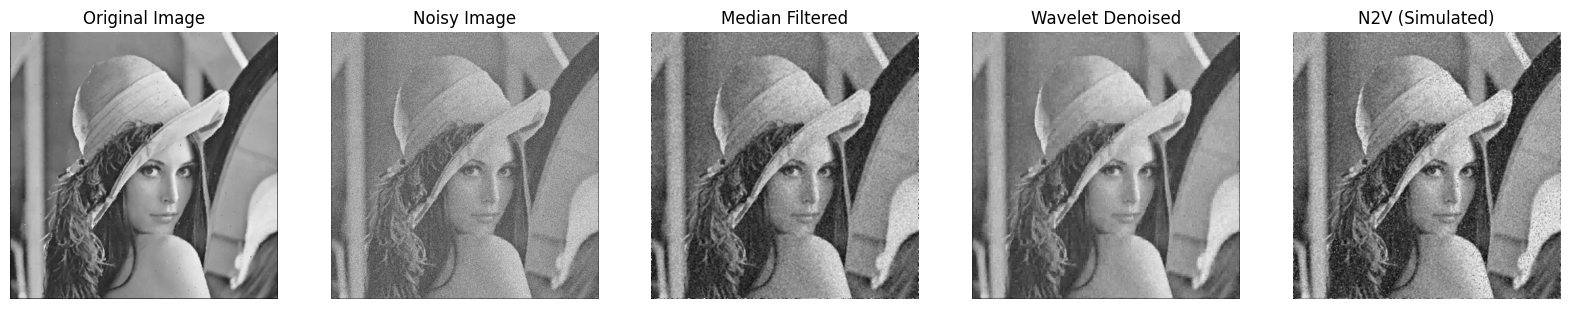

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.restoration import denoise_wavelet
from skimage import io, img_as_float
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error

# Load and add noise
img = img_as_float(io.imread('LenaImage.jpeg', as_gray=True))
noisy = img + 0.1 * np.random.randn(*img.shape)

# Median filter
median = cv2.medianBlur((noisy * 255).astype(np.uint8), 3)

# Wavelet denoising
wavelet = denoise_wavelet(noisy, channel_axis=None, rescale_sigma=True)

# Dummy Noise2Void-like (you can skip or simulate)
n2v = cv2.GaussianBlur((noisy * 255).astype(np.uint8), (3,3), 0)  # Placeholder

# Metrics
def compare(original, denoised):
    mse_val = mean_squared_error(original, denoised)
    psnr_val = peak_signal_noise_ratio(original, denoised, data_range=1.0)
    ssim_val = structural_similarity(original, denoised, data_range=1.0)
    return mse_val, psnr_val, ssim_val

# Comparison outputs
print("Wavelet:", compare(img, wavelet))
print("Median:", compare(img, median / 255.0))
print("N2V (simulated):", compare(img, n2v / 255.0))

# Visualization of results
fig, axes = plt.subplots(1, 5, figsize=(20, 8))
axes[0].imshow(img, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(noisy, cmap='gray')
axes[1].set_title("Noisy Image")
axes[1].axis('off')

axes[2].imshow(median / 255.0, cmap='gray')
axes[2].set_title("Median Filtered")
axes[2].axis('off')

axes[3].imshow(wavelet, cmap='gray')
axes[3].set_title("Wavelet Denoised")
axes[3].axis('off')

axes[4].imshow(n2v / 255.0, cmap='gray')
axes[4].set_title("N2V (Simulated)")
axes[4].axis('off')

plt.show()


In [ ]:
import cv2
vidcap = cv2.VideoCapture('bottle-detection.mp4')
success, image = vidcap.read()
count = 0

while success:
    cv2.imwrite(f"frames/frame_{count:04d}.jpg", image)
    success, image = vidcap.read()
    count += 1

print("Frames extracted:", count)


Frames extracted: 1189


In [ ]:
import cv2
import os

vidcap = cv2.VideoCapture('bottle-detection.mp4')
fps = int(vidcap.get(cv2.CAP_PROP_FPS))
width = int(vidcap.get(3))
height = int(vidcap.get(4))

out = cv2.VideoWriter('processed.avi', cv2.VideoWriter_fourcc(*'XVID'), fps, (width, height), isColor=True)

while True:
    ret, frame = vidcap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    threshold = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY, 11, 2)
    edges = cv2.Canny(blurred, 100, 200)
    inverted = cv2.bitwise_not(threshold)

    inverted_bgr = cv2.cvtColor(inverted, cv2.COLOR_GRAY2BGR)  # Convert back to 3-channel
    out.write(inverted_bgr)

vidcap.release()
out.release()



In [ ]:
import glob
from PIL import Image

images = sorted(glob.glob("frames/*.jpg"))[:16]
thumbs = [Image.open(img).resize((100, 100)) for img in images]
collage = Image.new('RGB', (400, 400))

i = 0
for y in range(0, 400, 100):
    for x in range(0, 400, 100):
        if i >= len(thumbs):
            break  # Exit inner loop
        collage.paste(thumbs[i], (x, y))
        i += 1


collage.save("collage.jpg")


In [ ]:
import cv2
import os
from PIL import Image
import glob
from IPython.display import HTML
from base64 import b64encode

# Load video
vidcap = cv2.VideoCapture('/content/bottle-detection.mp4')  # Update path if needed
fps = int(vidcap.get(cv2.CAP_PROP_FPS))
width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'XVID')

# Save to root so they appear in Colab's sidebar
out_thresh = cv2.VideoWriter('adaptive_thresh.avi', fourcc, fps, (width, height), True)
out_blur = cv2.VideoWriter('gaussian_blur.avi', fourcc, fps, (width, height), True)
out_canny = cv2.VideoWriter('canny.avi', fourcc, fps, (width, height), True)
out_invert = cv2.VideoWriter('bitwise_not.avi', fourcc, fps, (width, height), True)

os.makedirs("frames", exist_ok=True)
frame_count = 0

while True:
    ret, frame = vidcap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Processing steps
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
    blur_only = blurred
    edges = cv2.Canny(blurred, 100, 200)
    inverted = cv2.bitwise_not(gray)

    # Convert grayscale outputs to BGR before writing
    thresh_bgr = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    blur_bgr = cv2.cvtColor(blur_only, cv2.COLOR_GRAY2BGR)
    edges_bgr = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    inverted_bgr = cv2.cvtColor(inverted, cv2.COLOR_GRAY2BGR)

    # Write videos
    out_thresh.write(thresh_bgr)
    out_blur.write(blur_bgr)
    out_canny.write(edges_bgr)
    out_invert.write(inverted_bgr)

    if frame_count < 16:
        cv2.imwrite(f"frames/frame_{frame_count:04d}.jpg", frame)

    frame_count += 1

# Release
vidcap.release()
out_thresh.release()
out_blur.release()
out_canny.release()
out_invert.release()
print(f"Processed {frame_count} frames.")

# --- Collage ---
images = sorted(glob.glob("frames/*.jpg"))[:16]
thumbs = [Image.open(img).resize((100, 100)) for img in images]
collage = Image.new('RGB', (400, 400))

i = 0
for y in range(0, 400, 100):
    for x in range(0, 400, 100):
        if i < len(thumbs):
            collage.paste(thumbs[i], (x, y))
        i += 1

collage.save("collage.jpg")
print("Saved collage as collage.jpg")

# --- Display video inline ---
def show_video(filename):
    mp4_filename = filename.replace(".avi", ".mp4")
    os.system(f"ffmpeg -i {filename} -vcodec libx264 {mp4_filename} -y")
    mp4 = open(mp4_filename, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f'<video width=400 controls><source src="{data_url}" type="video/mp4"></video>')

# Show videos
display(show_video("adaptive_thresh.avi"))
display(show_video("gaussian_blur.avi"))
display(show_video("canny.avi"))
display(show_video("bitwise_not.avi"))


Processed 1189 frames.
Saved collage as collage.jpg


In [ ]:
!pip install kagglehub


In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = ""

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "matthewjansen/ucf101-action-recognition",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

<ipython-input-25-84d912f74f18>:10: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


ValueError: Unsupported file extension: ''. Supported file extensions are: .csv, .tsv, .json, .jsonl, .xml, .parquet, .feather, .sqlite, .sqlite3, .db, .db3, .s3db, .dl3, .xls, .xlsx, .xlsm, .xlsb, .odf, .ods, .odt

In [ ]:
import cv2
import numpy as np
import os
from keras.utils import to_categorical

def extract_frames(video_path, max_frames=16, step=5):
    frames = []
    cap = cv2.VideoCapture(video_path)
    i = 0
    while len(frames) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        if i % step == 0:
            frame = cv2.resize(frame, (112, 112))
            frames.append(frame)
        i += 1
    cap.release()
    return np.array(frames)

# Dataset preparation
data, labels = [], []
classes = os.listdir("UCF101_subset")
class_map = {cls: i for i, cls in enumerate(classes)}

for cls in classes:
    for vid in os.listdir(f"UCF101_subset/{cls}"):
        frames = extract_frames(f"UCF101_subset/{cls}/{vid}")
        if frames.shape[0] == 16:
            data.append(frames)
            labels.append(class_map[cls])

X = np.array(data)
y = to_categorical(labels, num_classes=len(classes))


FileNotFoundError: [Errno 2] No such file or directory: 'UCF101_subset'

In [ ]:
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense

model = Sequential([
    TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(16, 112, 112, 3)),
    TimeDistributed(MaxPooling2D((2,2))),
    TimeDistributed(Flatten()),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X, y, epochs=10, batch_size=2, validation_split=0.2)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes, target_names=classes))
